# Quantum Process Tomography Benchmarks

In [1]:
import sys
sys.path.insert(0, '../../src_tf/')

import numpy as np
import qiskit as qk
import matplotlib.pyplot as plt
import multiprocessing as mp
import random
import pickle

from qiskit.quantum_info import DensityMatrix, random_unitary
from qiskit.quantum_info import Operator
from scipy.linalg import sqrtm
from tqdm.notebook import tqdm

from loss_functions import *
from optimization import *
from quantum_channel import *
from kraus_channels import *
from lindblad_channels import *
from quantum_tools import *
from experimental import *
from spam import *

#np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(precision=4)

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

## Recover Map

### Generate True Model, Full POVM and Inital

In [2]:
def generate_spam_benchmark(n=3, c1=1, c2=1):
    d = 2**n

    init_target = InitialState(d, c=c1)
    povm_target = POVM(d, c=c2)

    spam_target = SPAM(init = init_target,
                       povm = povm_target)
    
    return spam_target


def generate_spam_data(spam_target, N_spam=None, shots=1024):
    n = int(np.log2(spam_target.d))
    inputs_spam, _ = generate_pauliInput_circuits(n)
    N_spam = inputs_spam.shape[0]

    state = tf.repeat(spam_target.init.init[None,:,:], N_spam, axis=0)
    targets_spam = measurement(state, U_basis = inputs_spam, povm = spam_target.povm.povm)

    #add noise
    targets_spam = generate_sampled_probs(targets_spam, shots = shots)
    return inputs_spam, targets_spam


def generate_map_data(channel_target, spam_target, N_map=None, shots=1024):
    n = int(np.log2(channel_target.d))
    inputs_map, _ = generate_pauli_circuits(n = n, 
                                            circuit_target=None,  
                                            trace=False,
                                            N=N_map)
    U_prep, U_basis = inputs_map

    N_map = U_prep.shape[0]
    state = tf.repeat(tf.expand_dims(spam_target.init.init, axis=0), N_map, axis=0)
    state = apply_unitary(state, U_prep)
    state = channel_target.apply_channel(state)
    targets_map = measurement(state, U_basis, spam_target.povm.povm)
    
    #add noise
    targets_map = generate_sampled_probs(targets_map, shots = shots)

    return inputs_map, targets_map


def model_pipeline(channel_target, noise, N_map = None, num_iter_spam=None, num_iter_map=None):
    # Make Benchmark
    #################################################################################
    n = 3
    d = 2**n
    
    spam_target = generate_spam_benchmark(n=n, c1=0.9, c2=0.9)
    inputs_spam, targets_spam = generate_spam_data(spam_target, N_spam=None, noise=noise)

    inputs_map, targets_map = generate_map_data(channel_target, spam_target, N_map=N_map, noise=noise)
    #################################################################################

    # Fit Models
    #################################################################################
    spam_model = SPAM(init = InitialState(d, c=0.9),
                      povm = CorruptionMatrix(d, c=0.9),
                      optimizer = tf.optimizers.Adam(learning_rate=0.01))
    
    #spam_model.pretrain(300, verbose=False)

    spam_model.train(inputs = inputs_spam,
                     targets = targets_spam,
                     num_iter = num_iter_map,
                     verbose = False,
                    )

    model = ModelQuantumMap(channel = KrausMap(d = d, 
                                               rank = d**2,
                                               spam = spam_model,
                                              ),
                            loss_function = ProbabilityMSE(),
                            optimizer = tf.optimizers.Adam(learning_rate=0.01),
                            logger = Logger(loss_function = ProbabilityMSE(),
                                            loss_function_val = channel_fidelity_loss),
                           )

    model.train(inputs = inputs_map,
                targets = targets_map,
                inputs_val = None,
                targets_val = [channel_target],
                num_iter = num_iter_map,
                N = 500,
                )
    #################################################################################
    model.optimizer = None
    spam_model.optimizer = None
    model.inputs = None
    model.targets = None
    model.inputs_val = None
    model.targets_val = None

    return model

### Generate Synthetic Data with Noise

In [24]:
n = 3
d = 2**n
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

spam_target = generate_spam_benchmark(n=n, c1=0.9, c2=0.9)
inputs_spam, targets_spam = generate_spam_data(spam_target, N_spam=None, noise=0)

channel_target = KrausMap(d = d,
                          rank = d**2
                         )
inputs_map, targets_map = generate_map_data(channel_target, spam_target, N_map=2000-6**n, noise=0)

In [30]:
samples = generate_sampled_probs(targets_map, shots = 1024)

In [31]:
print(samples)

tf.Tensor(
[[0 2 6 ... 0 3 3]
 [1 1 4 ... 1 0 0]
 [0 3 7 ... 0 7 6]
 ...
 [6 5 4 ... 5 4 4]
 [4 4 6 ... 4 6 7]
 [0 1 6 ... 0 0 1]], shape=(1784, 1024), dtype=int64)


In [32]:
samples = tf.one_hot(samples, targets_map.shape[1], dtype=precision)

In [33]:
samples = tf.math.reduce_mean(samples, axis=1)

In [34]:
print(samples)

tf.Tensor(
[[0.1514+0.j 0.126 +0.j 0.127 +0.j ... 0.1367+0.j 0.1074+0.j 0.1445+0.j]
 [0.1172+0.j 0.1279+0.j 0.1123+0.j ... 0.1182+0.j 0.1328+0.j 0.125 +0.j]
 [0.1523+0.j 0.1309+0.j 0.1006+0.j ... 0.1172+0.j 0.1299+0.j 0.1357+0.j]
 ...
 [0.1143+0.j 0.1211+0.j 0.1318+0.j ... 0.1172+0.j 0.1465+0.j 0.1543+0.j]
 [0.1289+0.j 0.1221+0.j 0.1084+0.j ... 0.125 +0.j 0.1338+0.j 0.1318+0.j]
 [0.1465+0.j 0.1357+0.j 0.1064+0.j ... 0.1162+0.j 0.1201+0.j 0.1426+0.j]], shape=(1784, 8), dtype=complex128)


### Fit Model, Initial and Corruption Matrix

In [35]:
targets_map

<tf.Tensor: shape=(1784, 8), dtype=complex128, numpy=
array([[0.1371-2.8314e-18j, 0.13  +4.4664e-18j, 0.1189-1.1168e-18j, ...,
        0.1354+1.5018e-18j, 0.1037+2.2455e-18j, 0.1343+1.8223e-18j],
       [0.1179+3.8333e-19j, 0.1346-8.1390e-19j, 0.1085+6.1772e-19j, ...,
        0.1153-1.1152e-18j, 0.1165-1.6766e-18j, 0.1221+2.8096e-18j],
       [0.1447-1.5962e-19j, 0.1241-2.2318e-18j, 0.1256+1.7902e-18j, ...,
        0.1147-8.0322e-19j, 0.1165+1.0634e-18j, 0.1308-2.3975e-19j],
       ...,
       [0.106 +4.0094e-18j, 0.1272+4.6134e-18j, 0.1505-6.6580e-20j, ...,
        0.109 -4.9091e-18j, 0.1304+1.8135e-18j, 0.149 -2.6515e-18j],
       [0.1304-1.0487e-18j, 0.1129+1.4394e-18j, 0.112 +1.7545e-18j, ...,
        0.126 +2.7295e-18j, 0.1247+3.4917e-19j, 0.1387-4.2595e-18j],
       [0.1405+3.2798e-19j, 0.1448+1.8084e-18j, 0.1135+2.6608e-19j, ...,
        0.1318+8.4363e-19j, 0.1172-6.1117e-21j, 0.1084+3.6087e-19j]])>

In [5]:
np.random.seed(43)
random.seed(43)
tf.random.set_seed(43)

spam_model = SPAM(init = InitialState(d, c=None),
                  povm = CorruptionMatrix(d, c=None),
                  loss_function = ProbabilityMSE(),
                  optimizer = tf.optimizers.Adam(learning_rate=0.01)
                 )

spam_model.pretrain(num_iter = 300)

spam_model.train(inputs = inputs_spam,
                 targets = targets_spam,
                 num_iter = 100,
                 verbose = False,
                )

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0.00015987754304711642


In [6]:
model = ModelQuantumMap(channel = KrausMap(d = d, 
                                           rank = d**2,
                                           spam = spam_model,
                                          ),
                        loss_function = KLDiv(),
                        optimizer = tf.optimizers.Adam(learning_rate=0.01),
                        logger = Logger(loss_function = KLDiv(),
                                        loss_function_val = channel_fidelity_loss),
                       )

model.train(inputs = inputs_map,
            targets = targets_map,
            inputs_val = None,
            targets_val = [kraus_target],
            num_iter = 200,
            N = 500,
            )

  0%|          | 0/200 [00:00<?, ?it/s]

0.03944259871838806 -0.11196273508997202
0.009739206521115776 -0.39898026441376494
0.0029479497417543685 -0.6696513064624774


In [7]:
pickle.dump(model.channel, open("test.p", "wb"))

### 

In [22]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

n = 4
d = 2**n
rank = d**2
c1 = 0.9
c2 = 0.9

#prep error and full POVM error

spam_target = SPAM(init = InitialState(d, c=c1),
                   povm = POVM(d, c=c2))
c = 0.3
U = generate_unitary(d)
kraus_target = DilutedKrausMap(U, c, kraus_part=KrausMap(d,d), spam = spam_target)

In [23]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

inputs_spam, _ = generate_pauliInput_circuits(n)

U_prep = inputs_spam
N_spam = U_prep.shape[0]

state = tf.repeat(spam_target.init.init[None,:,:], N_spam, axis=0)
state = apply_unitary(state, U_prep)
targets_spam = measurement(state, povm = spam_target.povm.povm)

#add noise
targets_spam = add_noise_to_probs(targets_spam, 1/2**5)

inputs_map, _ = generate_pauli_circuits(n = n, 
                                        N = 10000-6**n,
                                        circuit_target=None,  
                                        trace=False)
U_prep, U_basis = inputs_map
N_map = U_prep.shape[0]

N_map = U_prep.shape[0]
state = tf.repeat(tf.expand_dims(spam_target.init.init, axis=0), N_map, axis=0)
state = apply_unitary(state, U_prep)
state = kraus_target.apply_channel(state)
targets_map = measurement(state, U_basis, spam_target.povm.povm)

#add noise
targets_map = add_noise_to_probs(targets_map, 1/2**5)

In [25]:
np.random.seed(43)
random.seed(43)
tf.random.set_seed(43)

spam_model = SPAM(init = InitialState(d, c=None),
                  povm = CorruptionMatrix(d, c=None),
                  loss_function = ProbabilityMSE(),
                  optimizer = tf.optimizers.Adam(learning_rate=0.01)
                 )

spam_model.pretrain(num_iter = 300)

spam_model.train(inputs = inputs_spam,
                 targets = targets_spam,
                 num_iter = 2000,
                 verbose = False,
                )

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

0.0007390243732224467


In [29]:
model = ModelQuantumMap(channel = KrausMap(d = d, 
                                           rank = d,
                                           spam = spam_model,
                                          ),
                        loss_function = KLDiv(),
                        optimizer = tf.optimizers.Adam(learning_rate=0.01),
                        logger = Logger(loss_function = KLDiv(),
                                        loss_function_val = channel_fidelity_loss),
                       )

model.train(inputs = inputs_map,
            targets = targets_map,
            inputs_val = None,
            targets_val = [kraus_target],
            num_iter = 2000,
            N = 500,
            )

  0%|          | 0/2000 [00:00<?, ?it/s]

0.05893201890793587 -0.043120330505494846
0.030985282666204497 -0.14175343026700998
0.01716393176755223 -0.28712542332294966
0.013808107981035768 -0.3840585426206116
0.012037941306828562 -0.4651551244558699
0.010796472390462473 -0.5396333420264463
0.00985265234562124 -0.608253968636286
0.009147334314602669 -0.6685713484934901
0.008598518910124869 -0.7216059057683639
0.008173028033013566 -0.7673243436798233
0.007841370406286434 -0.8055518547745913
0.00758349260221969 -0.8373406876542655
0.007372583697702941 -0.8630963575578571
0.007207115725234566 -0.884087715132017
0.007082211078795187 -0.9000097759888502
0.006988726279376588 -0.9121482796054315
0.0069229743495687075 -0.921193743997957
0.006871769423920199 -0.9269971870478816
0.006841457502820162 -0.9310223758585843
0.006819126774414027 -0.934061682159776
0.006807254846257236 -0.936253970124644


In [30]:
spectrum1 = channel_spectrum(model.channel)
spectrum2 = channel_spectrum(kraus_target)

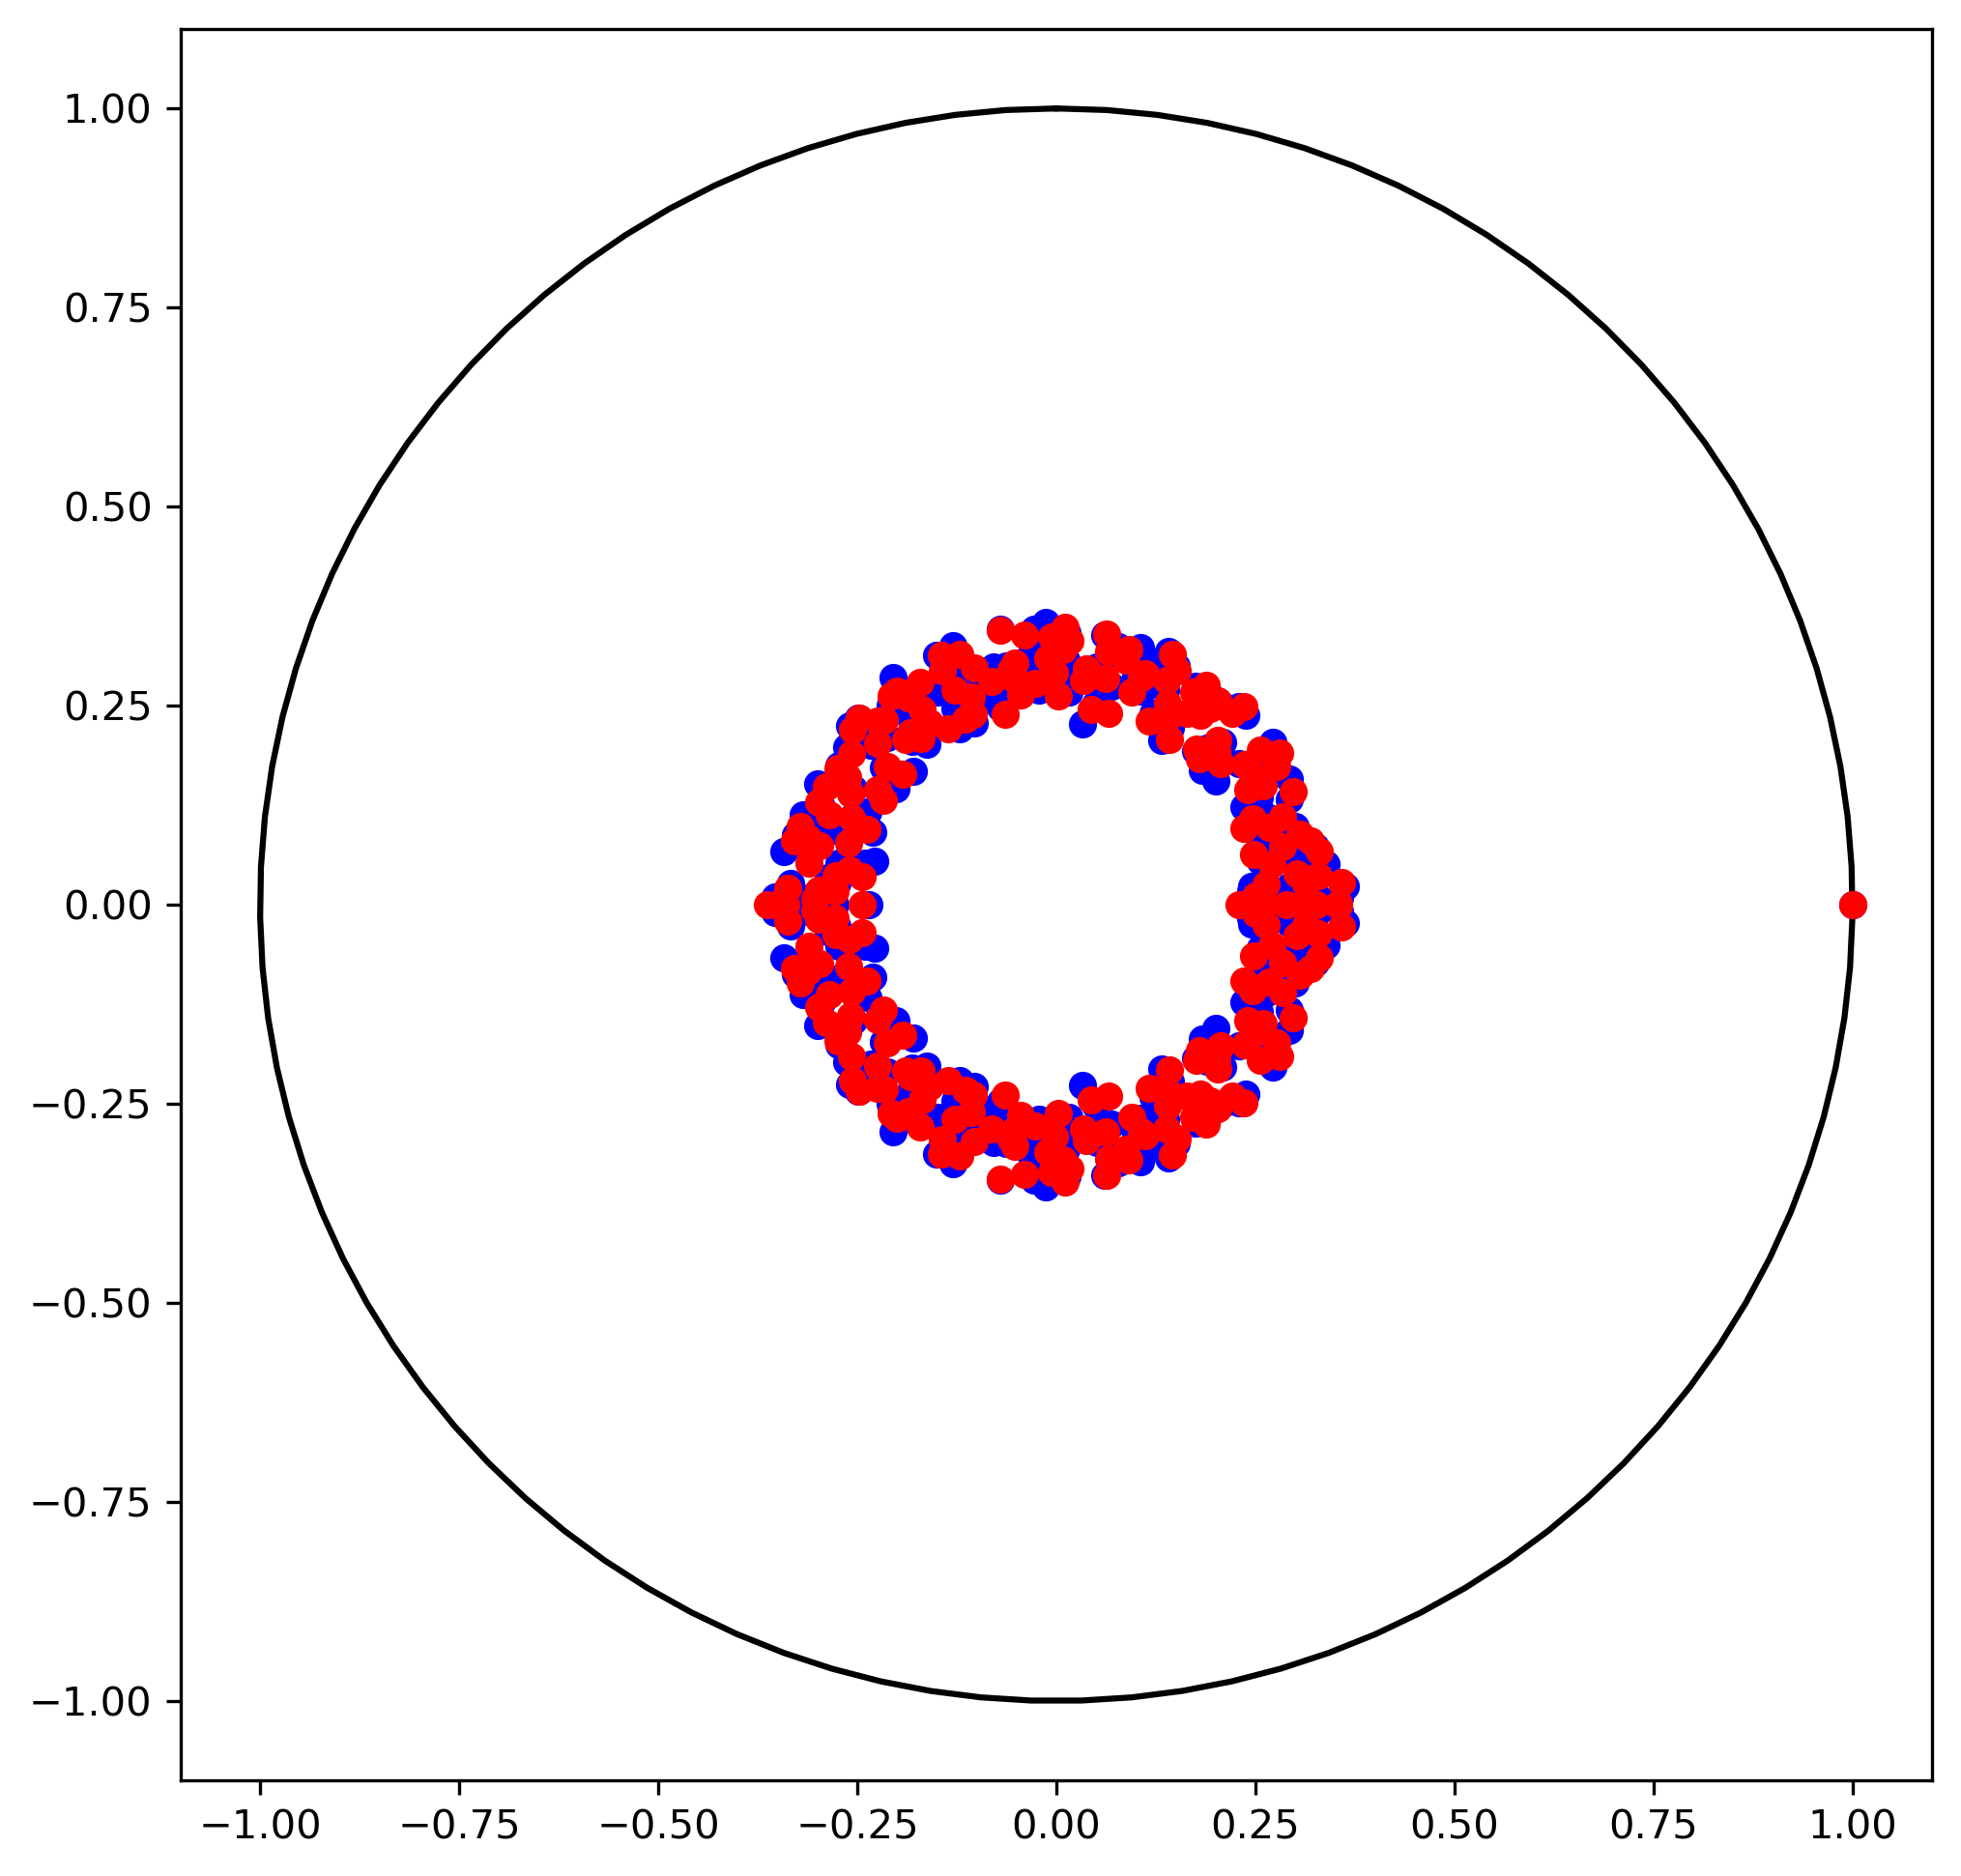

In [31]:
t = np.linspace(0, 2*np.pi, 100)
circle = [np.sin(t), np.cos(t)]

fig = plt.figure(figsize=(8,8), dpi = 300, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.set_aspect(1)
plt.plot(*circle, "k")

plt.plot(spectrum1[:,0], spectrum1[:,1], "bo")
plt.plot(spectrum2[:,0], spectrum2[:,1], "ro")


plt.show()